# Overview of Schelling's Model

The Nobel prize winning economist Thomas Schelling developed a model that shows  how global patterns of spatial segregation can arise from the effect of *homophily* operating at a local level.

*Homophily* is the principle that we tend to be similar to our friends and/or neighbors.

T. Schelling. Dynamic models of segregation. The Journal of Mathematical Sociology, 1(2), 143-186, 1971.

See also,
* J. M. Sakoda, The checkerboard model of social interaction. The Journalof Mathematical Sociology 1(1), 119-132, 1971.

* R. Hegselmann, Thomas C. Schelling and James M. Sakoda: The intellectual, technical, and social history of a model. Journal of Artificial Societies and Social Simulation 20 (3), 2017.




There are two components of the Schelling model: 

1. A grid representing different locations for the agents
2. A set of agents with two properties: 
    1. The agent type (e.g., 'red' or 'blue')
    2. The current position of the agent in the grid


An example of a grid with two types of agents: 

![grid.jpg](grid.jpg)

## Dynamics

At each round: 

1. For each agent $a$, determine the number of neighbors that are of the same type. 
2. Agent $a$ is happy if the number of similar agents is above a fixed threshold. 
3. If $a$ is not happy, then $a$  moves to an empty location.

Continue that process for a fixed number of rounds or until every agent is happy. 

## Questions

* How many agents are there? 
* What is the structure of the network? 
* How do you determine the neighbors of an agent? 
* Is the homophily threshold the same for all agents? 
* How densely populated is the network (how many free locations are there)?


## NetLogo Implementation 

[NetLogo Schelling Simulation](http://www.netlogoweb.org/launch#http://ccl.northwestern.edu/netlogo/models/models/Sample%20Models/Social%20Science/Segregation.nlogo)
 

## Implementing Schelling's Model using Python and Mesa

## Mesa 

[https://mesa.readthedocs.io/en/master/](https://mesa.readthedocs.io/en/master/)

In [1]:
from mesa import Agent

class SchellingAgent(Agent):
    '''
    Schelling segregation agent.
    '''
    def __init__(self, pos, agent_type):
        self.pos = pos
        self.type = agent_type
    def step(self):
        print("self is ", self)
        print("Inside step function. Agent type is ", self.type)

a = SchellingAgent((0,1),0)
print(a)
print(a.type)
print(a.pos)
a.step()

0
(0, 1)
self is  <__main__.SchellingAgent object at 0x1103e2f40>
Inside step function. Agent type is  0


In [2]:
a = SchellingAgent((0,0), 1)
b = SchellingAgent((0,1), 0)

print("a ", a)
print(a.pos)
print(a.type)
a.step()

print("\n")
print("b ", b)
print(b.pos)
print(b.type)
b.step()

a  <__main__.SchellingAgent object at 0x110405250>
(0, 0)
1
self is  <__main__.SchellingAgent object at 0x110405250>
Inside step function. Agent type is  1


b  <__main__.SchellingAgent object at 0x110405f40>
(0, 1)
0
self is  <__main__.SchellingAgent object at 0x110405f40>
Inside step function. Agent type is  0


In [3]:
from mesa import Model, Agent

class SchellingAgent(Agent):
    '''
    Schelling segregation agent
    '''
    def __init__(self, unique_id, pos, model, agent_type):
        '''
         Create a new Schelling agent.
         Args:
            pos: Agent initial location.
            agent_type: Indicator for the agent's type (minority=1, majority=0)
        '''
        super().__init__(unique_id, model)
        self.pos = pos
        self.type = agent_type

    def step(self):
        similar = 0
        neighbors = self.model.grid.neighbor_iter(self.pos)
        for neighbor in neighbors:
            if neighbor.type == self.type:
                similar += 1

        # If unhappy, move:
        if similar < self.model.homophily:
            self.model.grid.move_to_empty(self)
        else:
            self.model.happy += 1


Note that line 14 has the code 

```python 
super().__init__(pos,model)
```

First of all, note that `SchellingAgent` is a subclass of the mesa class `Agent`. 

`super()` is a builtin function that gives access to the base class. The use case of this function is illustrated below:   

In [4]:
class A():
    def __init__(self, param):
        print("initializing A with ", param)
        self.A_parameter = param
        self.param2 = "Another parameter"
        
class B(A):
    def __init__(self, param):
        print("B is a subclass of A")
        self.B_parameter = param

b = B(7)
print(b.param2) # produces an error since the base class hasn't been initialized

B is a subclass of A


AttributeError: 'B' object has no attribute 'param2'

The problem with the above code is that when initializing the class B we didn't call the `__init__` method of the base class.   There are two ways to do this: 

The first approach is to explicitly call the base class `__init__` method


In [5]:
# 1. The first approach is to explicitly reference the base class __init__ function
class A():
    def __init__(self, param):
        print("Initializing A with ", param)
        self.A_parameter = param
        self.param2 = "Another parameter"
        
class B(A):
    def __init__(self, param):
        print("Initializing B with ", param)
        self.B_parameter = param
        A.__init__(self, param)

b = B(42)
print(f"b.param2 is {b.param2}") # now b can access the base class attributes
print(f"b.B_parameter is {b.B_parameter}")
print(f"b.A_parameter is {b.A_parameter}")



Initializing B with  42
Initializing A with  42
b.param2 is Another parameter
b.B_parameter is 42
b.A_parameter is 42


The second approach is the use the builtin `super()`:

In [6]:
# 2. The second (preferable) approach is to use the builtin super()

class A():
    def __init__(self, param):
        print("Initializing A with ", param)
        self.A_parameter = param
        self.param2 = "Another parameter"

class B(A):
    def __init__(self, param):
        print("Initializing B with ", param)
        self.B_parameter = param
        super().__init__(param)

b = B(7)
print(f"b.param2 is {b.param2}") # now b can access the base class attributes
print(f"b.B_parameter is {b.B_parameter}")
print(f"b.A_parameter is {b.A_parameter}")



Initializing B with  7
Initializing A with  7
b.param2 is Another parameter
b.B_parameter is 7
b.A_parameter is 7


In [7]:
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
import random 

class SchellingModel(Model):
    '''
    Model class for the Schelling segregation model.
    '''
    def __init__(self, height, width, density, minority_percent, homophily):
        
        self.height = height
        self.width = width
        self.density = density
        self.minority_percent = minority_percent
        self.homophily = homophily

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(height, width, torus=True)

        self.happy = 0
        self.datacollector = DataCollector(
            {"happy": lambda m: m.happy},  # Model-level count of happy agents
            # For testing purposes, agent's individual x and y
            {"x": lambda a: a.pos[0], "y": lambda a: a.pos[1]})
        self.running = True
        # Set up agents
        agent_id = 0
        for cell in self.grid.coord_iter():
            #print(cell)
            _,x,y = cell
            if random.random() < self.density:
                if random.random() < self.minority_percent:
                    agent_type = 1
                else:
                    agent_type = 0
                agent = SchellingAgent(agent_id, (x, y), self, agent_type)
                agent_id += 1
                self.grid.position_agent(agent, x=x, y=y)
                self.schedule.add(agent)
        
    def step(self):
        '''
        Run one step of the model. If All agents are happy, halt the model.
        '''
        self.happy = 0  # Reset counter of happy agents
        self.schedule.step()
        self.datacollector.collect(self)
        if self.happy == self.schedule.get_agent_count():
            self.running = False


Create a model instance: a 10x10 grid, a 10% chance of an agent being placed in each cell, approximately 20% of agents set as minorities, and each agent wants at least 3 similar neighbors.

In [8]:
height, width = 10, 10
density = 0.1
minority_percent = 0.2
homophily = 4
model = SchellingModel(height, width, density, minority_percent, homophily)
print("Display the first 5 agents:\n")
for a in model.schedule.agents[0:5]: 
    print(a)
    print("type is ", a.type)
    print(f"pos is {a.pos}")
    print(f"unique id is {a.unique_id}\n")


Display the first 5 agents:

type is  0
pos is (0, 5)
unique id is 0

type is  0
pos is (6, 7)
unique id is 1

type is  0
pos is (7, 0)
unique id is 2

type is  0
pos is (7, 6)
unique id is 3

type is  0
pos is (8, 0)
unique id is 4



In [9]:
# execute one round of the models
model.step()

# some positions should change
for a in model.schedule.agents[0:5]: 
    print(a)
    print("type is ", a.type)
    print(f"pos is {a.pos}")
    print(f"unique id is {a.unique_id}")
    print(f"model.happy = {model.happy}\n")


type is  0
pos is (6, 2)
unique id is 0
model.happy = 0

type is  0
pos is (0, 7)
unique id is 1
model.happy = 0

type is  0
pos is (0, 6)
unique id is 2
model.happy = 0

type is  0
pos is (2, 2)
unique id is 3
model.happy = 0

type is  0
pos is (4, 4)
unique id is 4
model.happy = 0



Note that on line 17 of the definition of `SchellingModel` we have the following code: 

```python
self.schedule = RandomActivation(self)
```

This activates the agents one at a time in random order with the order reshuffled every step of the model. 

See [the source code](https://mesa.readthedocs.io/en/stable/_modules/mesa/time.html#RandomActivation) for details. 


In [10]:
# To illustrate the RandomAcitivation scheduler, note that running this
# multiple times will produce different orders of the agents

print([a.unique_id for a in model.schedule.agent_buffer(shuffled=True)])

[1, 6, 3, 5, 7, 2, 0, 4]


Note that  line 18 of the definition of the `SchellingModel` has the following code: 
    
```python
self.grid = SingleGrid(height, width, torus=True)
```

This defines a grid to place the agents. 

See [the course code](https://mesa.readthedocs.io/en/master/_modules/space.html#SingleGrid) for details. 


In [11]:
# create a simple Schelling model with a 3x3 grid
model2 = SchellingModel(3, 3, 0, 0.2, 4)

# each cell is a tuple where the first component is the agent, 
# the second component is the x position and 
# the 3rd component is the y position
for cell in model2.grid.coord_iter():
    print(cell)


(None, 0, 0)
(None, 0, 1)
(None, 0, 2)
(None, 1, 0)
(None, 1, 1)
(None, 1, 2)
(None, 2, 0)
(None, 2, 1)
(None, 2, 2)


In [12]:
a1 = SchellingAgent(0, (1, 1), model2, 0)

# initially position the agent at 1,1
model2.grid.position_agent(a1, x=1, y=1)

for cell in model2.grid.coord_iter():
    print(cell)
print(f"\na1 pos is {a1.pos}")


(None, 0, 0)
(None, 0, 1)
(None, 0, 2)
(None, 1, 0)
(<__main__.SchellingAgent object at 0x1104d1460>, 1, 1)
(None, 1, 2)
(None, 2, 0)
(None, 2, 1)
(None, 2, 2)

a1 pos is (1, 1)


In [13]:

# now move a1 to an empty location
model2.grid.move_to_empty(a1)

for cell in model2.grid.coord_iter():
    print(cell)
print(f"\na1 pos is {a1.pos}")


(None, 0, 0)
(None, 0, 1)
(<__main__.SchellingAgent object at 0x1104d1460>, 0, 2)
(None, 1, 0)
(None, 1, 1)
(None, 1, 2)
(None, 2, 0)
(None, 2, 1)
(None, 2, 2)

a1 pos is (0, 2)


In [14]:
model2 = SchellingModel(3, 3, 0, 0.2, 4)
model2.grid = SingleGrid(3, 3, torus=True)

a1 = SchellingAgent(1, (1, 1), model2, 0)
a2 = SchellingAgent(2, (1, 0), model2, 0)
a3 = SchellingAgent(3, (0, 0), model2, 0)
a4 = SchellingAgent(4, (2, 2), model2, 0)

model2.grid.position_agent(a1, x=1, y=1)
model2.grid.position_agent(a2, x=1, y=0)
model2.grid.position_agent(a3, x=0, y=0)
model2.grid.position_agent(a4, x=2, y=2)

print("The neighbors of a1 are: ")
for n in model2.grid.neighbor_iter(a1.pos):
    print(f"a{n.unique_id} at {n.pos}")
    
print("The neighbors of a3 are: ")
for n in model2.grid.neighbor_iter(a3.pos):
    print(f"a{n.unique_id} at {n.pos}")

The neighbors of a1 are: 
a3 at (0, 0)
a2 at (1, 0)
a4 at (2, 2)
The neighbors of a3 are: 
a4 at (2, 2)
a2 at (1, 0)
a1 at (1, 1)


Lines 31 - 35 of the `SchellingModel` has the following code: 

```python
if random.random() < self.density:
    if random.random() < self.minority_percent:
        agent_type = 1
    else:
        agent_type = 0
```


`random.random()` returns a random floating point number in the range $[0.0, 1.0)$.

With probability `density` create an agent at the position.  With probability `minority_percent` set the agent type to 1 (a minority agent) otherwise set the agent type to 0 (a majority agent). 

Instatiate a model instance: a 10x10 grid, with an 80% chance of an agent being placed in each cell, approximately 20% of agents set as minorities, and agents wanting at least 3 similar neighbors.  Run the model at most 100 times. 

In [15]:
height, width = 50, 50
density = 0.8
minority_percent = 0.3
homophily = 4
model = SchellingModel(height, width, density, minority_percent, homophily)

while model.running and model.schedule.steps < 1000:
    model.step()
print(f"The model ran for {model.schedule.steps} steps") # Show how many steps have actually run

The model ran for 322 steps


Lines 21 - 24 of the definition of the `SchellingModel` has the following code: 

```python 
self.datacollector = DataCollector(
{"happy": lambda m: m.happy},  # Model-level count of happy agents
# For testing purposes, agent's individual x and y
{"x": lambda a: a.pos[0], "y": lambda a: a.pos[1]})
```

This code is called in the `step()` method on line 47: 

```python
self.datacollector.collect(self)
```

The `DataCollector` is a simple, standard way to collect data generated by a Mesa model. It collects three types of data: model-level data, agent-level data, and tables.

See the [documentation for details](https://mesa.readthedocs.io/en/stable/apis/datacollection.html).

The code uses the builtin `lambda` to define a function.

To define a function in Python you need to use the `def` keyord, specify a name of the fucntion, list the parameters and the function body. The `lambda` builtin allows you to quickly define functions on the fly. 

In [16]:
def f1(p):
    return p + 2

print(f1(2))

f2 = lambda p: p + 2

print(f2(2))

4
4


Use the method `get_model_vars_dataframe` to get the model-level data after running the model.  

Use the method `get_agent_vars_dataframe` to get the agent-level data after running the model.  

Both returna a [Pandas dataframe](https://pandas.pydata.org/).  Pandas is a popular tool for data analysis and manipulation. 

In [17]:
import pandas as pd 

data = {
    "var1": [1, 2, 3, 4, 5], 
    "var2": ["a", "b", "c", "d", "e"],
    "var3": [1, None, "a", 2.0, "c"]
}

df = pd.DataFrame(data)

df

,var1,var2,var3
0,1,a,1
1,2,b,None
2,3,c,a
3,4,d,2.0
4,5,e,c


We will discuss Pandas in more detail later in the course.   For now, see the [10-minute introduction to Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html).     

In [18]:
model_out = model.datacollector.get_model_vars_dataframe()
model_out

,happy
0,1221
1,1440
2,1571
3,1647
4,1721
...,...
317,2012
318,2012
319,2012
320,2012


In [19]:
# use describe() to get basic statistics about the data
model_out.describe()


,happy
count,322.000000
mean,1992.049689
std,70.017470
min,1221.000000
25%,2002.000000
50%,2010.000000
75%,2012.000000
max,2013.000000


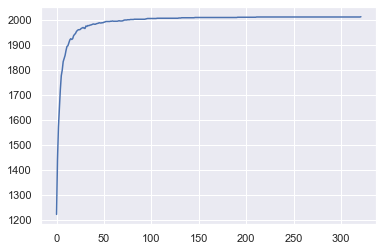

In [20]:
import seaborn as sns
sns.set()

model_out.happy.plot();

In [21]:
agent_out = model.datacollector.get_agent_vars_dataframe()
agent_out.head()

x   y
Step AgentID        
1    0         0   1
     1         0   2
     2         0   3
     3         0   6
     4        17  47

## Exploring the Parameter Space

In [22]:
from mesa.batchrunner import BatchRunner

def get_segregation(model):
    '''
    Find the % of agents that only have neighbors of their same type.
    '''
    segregated_agents = 0
    for agent in model.schedule.agents:
        segregated = True
        for neighbor in model.grid.neighbor_iter(agent.pos):
            if neighbor.type != agent.type:
                segregated = False
                break
        if segregated:
            segregated_agents += 1
    return segregated_agents / model.schedule.get_agent_count()

In [23]:
variable_params = {"homophily": range(1,9)}
fixed_params =  {"height": 10, "width": 10, "density": 0.8, "minority_percent": 0.2} 
model_reporters = {"Segregated_Agents": get_segregation}
param_sweep = BatchRunner(SchellingModel, 
                          variable_params, 
                          fixed_params, 
                          iterations=10, 
                          max_steps=200, 
                          model_reporters=model_reporters, 
                          display_progress=False)

In [24]:
param_sweep.run_all()

In [25]:
df = param_sweep.get_model_vars_dataframe()
df

,homophily,Run,Segregated_Agents,height,width,density,minority_percent
0,1,0,0.302632,10,10,0.8,0.2
1,1,1,0.407895,10,10,0.8,0.2
2,1,2,0.400000,10,10,0.8,0.2
3,1,3,0.311688,10,10,0.8,0.2
4,1,4,0.230769,10,10,0.8,0.2
...,...,...,...,...,...,...,...
75,8,75,0.113924,10,10,0.8,0.2
76,8,76,0.208333,10,10,0.8,0.2
77,8,77,0.387500,10,10,0.8,0.2
78,8,78,0.139241,10,10,0.8,0.2


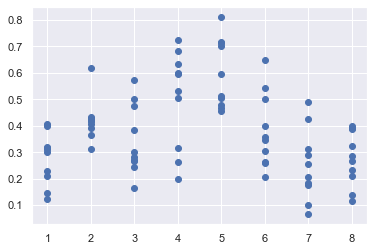

In [26]:
import matplotlib.pyplot as plt

plt.scatter(df.homophily, df.Segregated_Agents)
plt.grid(True)


## Additional Reading


* Brian Hayes, [The Math of Segregation](https://www.americanscientist.org/article/the-math-of-segregation), American Scientist.
  
*   Christina Brandt, Nicole Immorlica, Gautam Kamath, and Robert Kleinberg, [An Analysis of One-Dimensional Schelling Segregation](https://arxiv.org/abs/1203.6346), Proceedings of the forty-fourth annual ACM symposium on theory of computing,  2012. 

* Matthew Jackson, Chapter 5, The Human Network: How Your Social Position Determines Your Power, Beliefs, and Behaviors,  Vintage, 2020.

* David Easley and Jon Kleinberg, Section 4.5, [Networks, Crowds, and Markets: Reasoning about a Highly Connected World](https://www.cs.cornell.edu/home/kleinber/networks-book/networks-book-ch04.pdf), Cambridge University Press, 2010

* [Parable of the Polygons](https://ncase.me/polygons/)